In [72]:
# Inserção/instalação dos pacotes para lista 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels

from sklearn.model_selection import train_test_split

### 1) Considere a série Taxa de crescimento trimestral do produto nacional bruto real dos EUA (*quarterly growth rate of the U.S. real gross national product*  - GNP), do segundo trimestre de 1947 ao primeiro trimestre de 1991. (Fonte: R.S. TSAY - *Analysis of Financial Time Series* 2nd Ed).

In [73]:
# Inicialização do Exercício 1
gnp = pd.read_csv('./dados/dgnp82.txt',header=None, names=["data"])
gnp['time'] = pd.date_range('1947-01', periods=len(gnp['data']), freq='QS') #Cria escala de tempo trimestral (quarters)
gnp = gnp.set_index('time') #Cría índice temporal
gnp.head()

,data
time,
1947-01-01,0.00632
1947-04-01,0.00366
1947-07-01,0.01202
1947-10-01,0.00627
1948-01-01,0.01761


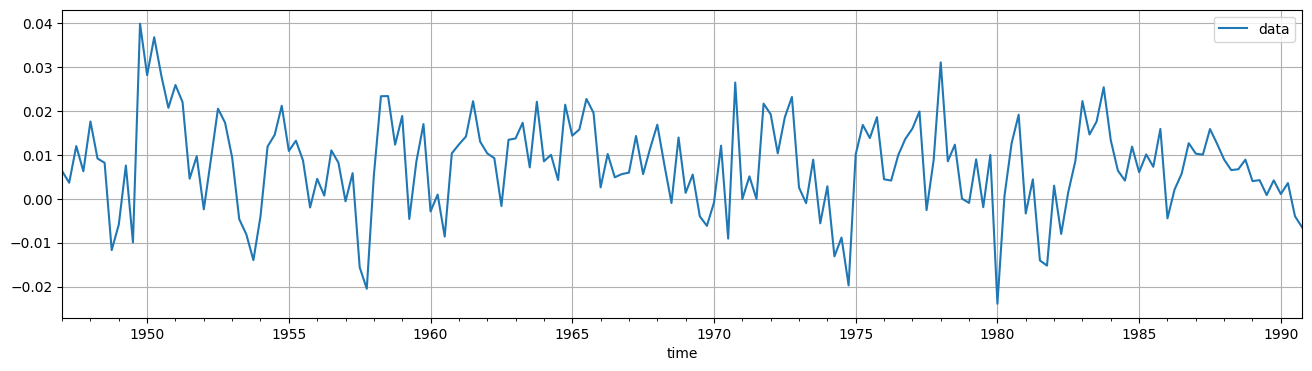

In [74]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
_ = gnp.data.plot(ax=ax, legend=True)
plt.grid()

A série não parece ter uma tendência

#### 1.a) Verifique se a série é estacionária. Comprove com o teste de Dickey Fuller aumentado, justificando a escolha da defasagem.

In [75]:
# Teste de Dickey-Fuller aumentado com drift
adf_gnp = adfuller(gnp.data, regression='c', maxlag=10, autolag='AIC')

print(f'ADF Statistic: {adf_gnp[0]}')
print(f'p-value: {adf_gnp[1]}')
print(f'Lags: {adf_gnp[2]}')

for key, value in adf_gnp[4].items():
    print('Critial Values:')
    print(f'    {key}: {value}')

ADF Statistic: -6.487076153093329
p-value: 1.253155591091127e-08
Lags: 2
Critial Values:
    1%: -3.4687256239864017
Critial Values:
    5%: -2.8783961376954363
Critial Values:
    10%: -2.57575634100705


**Como a estatística é menor do que o tau crítico para os valores críticos, e o p-valor é (muito) menor que 1%, rejeitamos a hipótese nula e aceitamos que a série não possui raiz unitária e é estacionária**

A defasagem pode ser selecionada automaticamente pelo pacote statsmodels, minimizando o critério AIC. Neste caso, a defasagem selecionada é de 2.

#### 1.b) Faça os gráficos das funções de autocorrelação e autocorrelação parcial da série. O que se pode inferir sobre a ordem do modelo? Justifique!

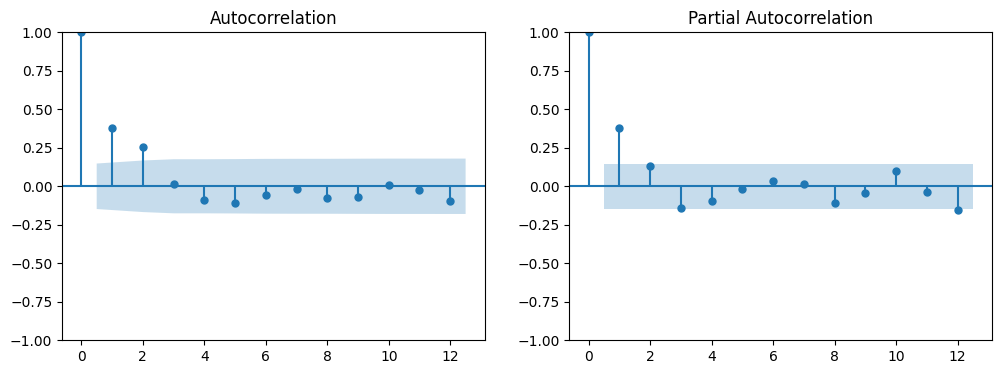

In [76]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
fig = statsmodels.graphics.tsaplots.plot_acf(gnp.data, lags=12, ax=ax1)
ax2 = fig.add_subplot(122)
fig = statsmodels.graphics.tsaplots.plot_pacf(gnp.data, lags=12, ax=ax2)
plt.show()

**Podemos observar uma correlação entre a observação e até 2 atrasos, corroborada pela função de autocorrelação parcial. Assim, a ordem do modelo parecer ser MA(2) e possivelmente AR(2)**

#### 1.c) Gere, com os dados da série, modelos ARMA(p, q), p = 0, 1, 2, 3 ; q = 0, 1, 2, 3, exceto com p = q = 0. Faça uma tabela com os 15 valores encontrados, considerando o p-value do teste de independência do resíduo do modelo e o critério AICc. Com base na tabela, escolha o melhor modelo dentre os testados. Faça a análise gráfica do resultado.


Separando os dados em teste (5 exemplos) e treino (171 exemplos)

In [77]:
gnp_train, gnp_test = train_test_split(gnp, test_size=0.025, shuffle=False)
gnp_train.tail()

,data
time,
1988-07-01,0.00673
1988-10-01,0.00892
1989-01-01,0.00402
1989-04-01,0.00425
1989-07-01,0.00085


In [78]:
gnp_test

,data
time,
1989-10-01,0.00420
1990-01-01,0.00108
1990-04-01,0.00358
1990-07-01,-0.00399
1990-10-01,-0.00650


In [79]:
p = range(0,4)
q = range(0,4)
d = range(0,1)
pdq = list(itertools.product(p,d,q))
pq = [(p,d,q) for p,d,q in pdq if (p !=0 or q!=0)]

ARMA_aic = []
ARMA_pval = []

ljungbox_lag = 10

for param in pq:
    try:
        ARMA_ = ARIMA(gnp_train, order=param)
        res = ARMA_.fit()
        AUX = acorr_ljungbox(res.resid, lags=[ljungbox_lag])
        ARMA_pval.append(AUX.lb_pvalue[ljungbox_lag])
        ARMA_aic.append(res.aicc)
        if res.aicc <= min(ARMA_aic):
            BEST_param = param
    except Exception as e:
        print(e)
        print(f'Failed for param {param}')
        continue

#Gera tabela
data = {'AICc':  ARMA_aic,
        'Pval': ARMA_pval}

df_ARMA = pd.DataFrame(data, index = pq).rename_axis('ARMA',axis=1)
print(f"Melhor parâmetro: {BEST_param}")
df_ARMA


Melhor parâmetro: (2, 0, 2)


ARMA,AICc,Pval
"(0, 0, 1)",-1076.908441,0.082248
"(0, 0, 2)",-1087.482093,0.597191
"(0, 0, 3)",-1087.249938,0.718040
"(1, 0, 0)",-1084.259112,0.372206
"(1, 0, 1)",-1083.642348,0.450578
"(1, 0, 2)",-1086.591761,0.675668
"(1, 0, 3)",-1085.059302,0.699159
"(2, 0, 0)",-1085.028302,0.499623
"(2, 0, 1)",-1084.282290,0.594023
"(2, 0, 2)",-1087.815629,0.880745


Baseado na tabela, podemos ver que os p-values são todos maiores do que um nível de significância pequeno (e.g 5\%). Sendo assim, **Não** podemos rejeitar a hipótese nula de que os dados são independentes, ou seja, concluímos que não há autocorrelações significativas nos residuais.

Pelo critério de AIC, temos que o melhor modelo é **$(2,0,2)$**

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  171
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 550.164
Date:                Fri, 04 Aug 2023   AIC                          -1088.328
Time:                        18:43:25   BIC                          -1069.478
Sample:                    01-01-1947   HQIC                         -1080.679
                         - 07-01-1989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.001      6.630      0.000       0.006       0.010
ar.L1          0.5754      0.223      2.582      0.010       0.139       1.012
ar.L2         -0.4214      0.176     -2.399      0.0

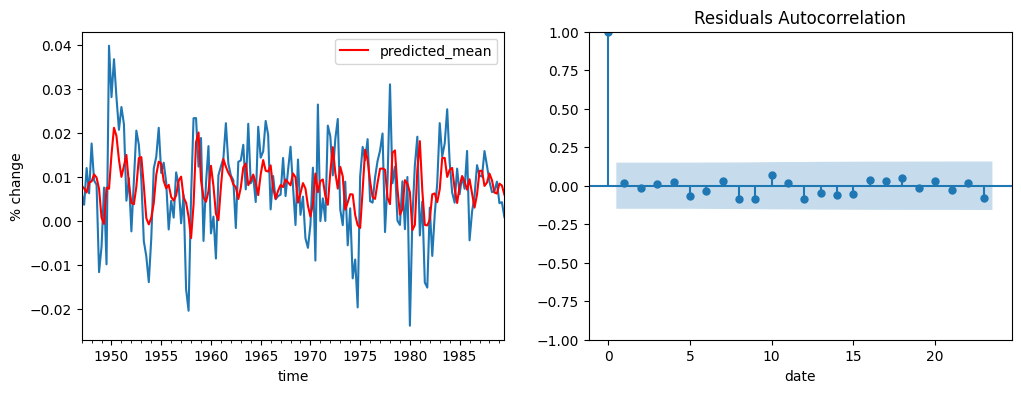

In [80]:
BEST_ARMA = ARIMA(gnp_train, order=(BEST_param))
res_BEST_ARMA = BEST_ARMA.fit()
print(res_BEST_ARMA.summary())

BEST_ARMA_predict = pd.DataFrame(res_BEST_ARMA.predict())
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
gnp_train.data.plot(ax=ax1)
BEST_ARMA_predict.plot(ax=ax1,color='red')
plt.ylabel("% change");
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_acf(res_BEST_ARMA.resid,ax=ax2)
plt.xlabel("lags")
plt.title("Residuals Autocorrelation")
plt.xlabel("date")
plt.show()

Pvalor: 1     0.793381
2     0.951529
3     0.989307
4     0.993506
5     0.959658
6     0.973235
7     0.984359
8     0.944057
9     0.891889
10    0.880745
Name: lb_pvalue, dtype: float64


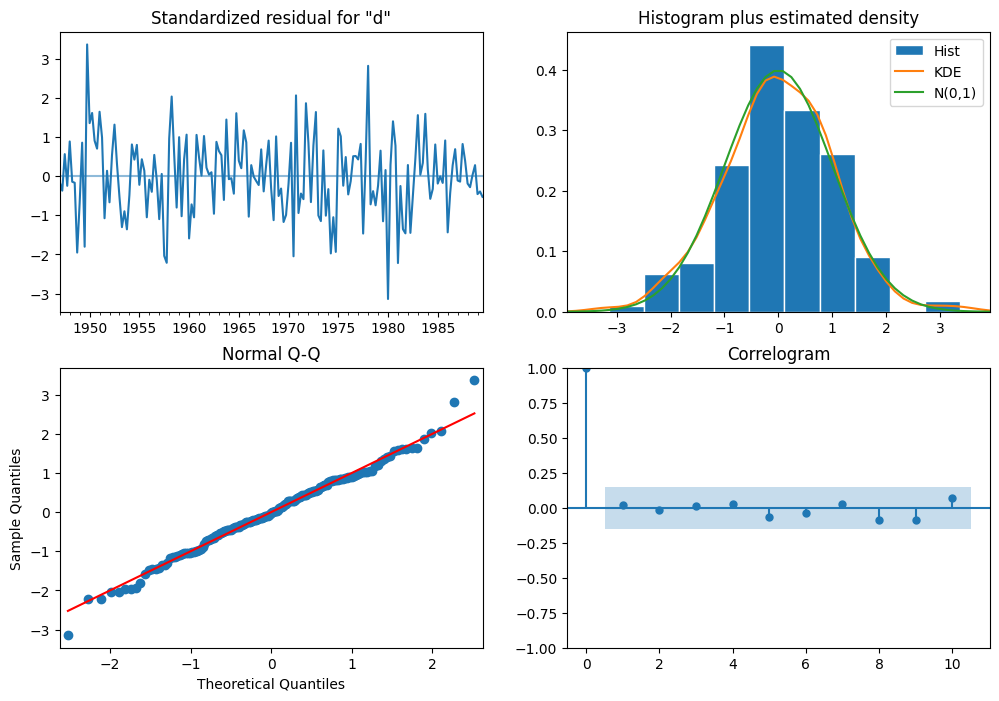

In [81]:
# Diagnóstico do resíduo do modelo
AUX = acorr_ljungbox(res_BEST_ARMA.resid)
AUX_Pval = AUX.lb_pvalue
print(f'Pvalor: {AUX_Pval}')
res_BEST_ARMA.plot_diagnostics(figsize=(12,8))
plt.show()

#### 1.d) Obtenha as previsões da série até cinco passos à frente com o melhor modelo obtido no item 1.c). Mostre o gráfico das previsões com intervalo de confiança de 95%.

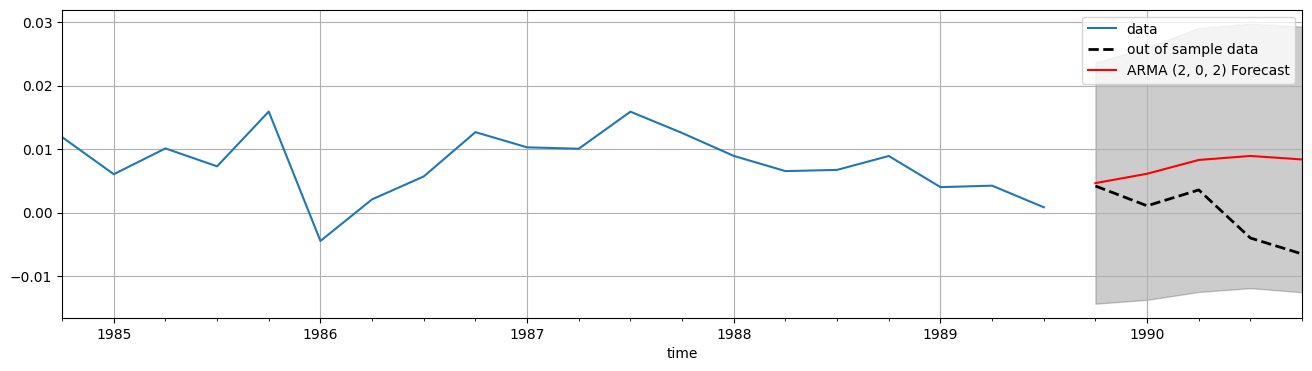

Forecast ARMA (2, 0, 2):
Model MAPE: 94.24817257231591


In [85]:
periods = 5
index_ahead = gnp_test.index

fcast_BEST_ARMA = res_BEST_ARMA.get_forecast(periods)
fcast_BEST_ARMA_mean = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean']
fcast_BEST_ARMA_low = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_lower']
fcast_BEST_ARMA_up = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_upper']
fcast_BEST_ARMA_mean = fcast_BEST_ARMA_mean.rename('ARMA '+str(BEST_param)+' Forecast')

## Gráficos das previsões
fig, ax = plt.subplots(1,1,figsize=(16,4))
gnp_train.data[-20:].plot(ax=ax, legend=True)
gnp_test.data.plot(ax=ax, color='k', ls='--', lw=2, label='out of sample data', legend=True)

fcast_BEST_ARMA_mean.plot(ax=ax, color='red', legend=True)
ax.fill_between(index_ahead, fcast_BEST_ARMA_low, fcast_BEST_ARMA_up, color='k',alpha=0.2)
plt.grid()
plt.show()

## Imprime as previsões
print(f'Forecast ARMA {BEST_param}:')
summary = fcast_BEST_ARMA.summary_frame(alpha=0.05)
summary['abs_percent_error'] = np.abs((summary['mean'] - gnp_test['data'])/summary['mean'])
summary
print(f'Model MAPE: {summary.abs_percent_error.mean()*100}')

### 2) Considere a série temporal logarítmica trimestral do produto interno bruto dos EUA (U.S. quarterly gross domestic product – GDP) desde o primeiro trimestre de 1947 até o quarto trimestre de 2003 (Fonte: R.S. TSAY - Analysis of Financial Time Series 2nd Ed). OBS: para análise, deve-se tomar o log da série original.

In [52]:
# Inicialização do Exercício 2
gdp = pd.read_csv('./dados/GDP.csv',header=None, names=["temp", "gdp"])
gdp['gdp_log'] = np.log(gdp['gdp'])
gdp['time'] = pd.date_range('1947-01', periods=len(gdp['gdp']), freq='QS') #Cria escala de tempo trimestral (quarters)
gdp = gdp.set_index('time') #Cría índice temporal
gdp.drop('temp', inplace=True, axis=1)
gdp.drop('gdp', inplace=True, axis=1)
gdp = gdp.dropna()
print(gdp.describe().T)
gdp.head()


         count      mean       std       min       25%       50%       75%  \
gdp_log  228.0  7.449125  1.209244  5.468904  6.284987  7.398846  8.620644   

             max  
gdp_log  9.32919  


,gdp_log
time,
1947-01-01,5.468904
1947-04-01,5.482720
1947-07-01,5.499624
1947-10-01,5.538908
1948-01-01,5.562219


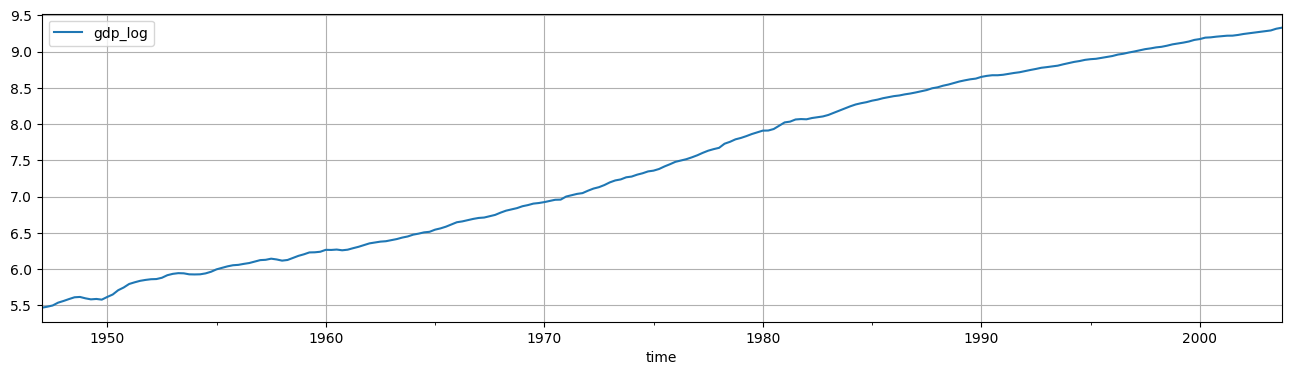

In [86]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
_ = gdp.gdp_log.plot(ax=ax, legend=True)
plt.grid()

A série apresenta uma forte tendência temporal

#### 2.a) Verifique se a série resultante é estacionária. Comprove com o teste de Dickey Fuller aumentado, justificando a escolha da defasagem.

In [54]:
# Teste de Dickey-Fuller aumentado com drift
adf_gdp = adfuller(gdp.gdp_log, regression='ct', maxlag=20, autolag='AIC')

print(f'ADF Statistic: {adf_gdp[0]}')
print(f'p-value: {adf_gdp[1]}')
print(f'Lags: {adf_gdp[2]}')

for key, value in adf_gdp[4].items():
    print('Critial Values:')
    print(f'    {key}: {value}')

ADF Statistic: -2.798063308372963
p-value: 0.19765668038012502
Lags: 18
Critial Values:
    1%: -4.0027517721652925
Critial Values:
    5%: -3.4317085320958416
Critial Values:
    10%: -3.139513599307244


**Como a estatística é maior do que o tau crítico para os valores críticos, e o p-valor é maior que 1%, aceitamos a hipótese nula de que a série possui raiz unitária e não é estacionária**

A defasagem pode ser selecionada automaticamente pelo pacote statsmodels, minimizando o critério AIC. Neste caso, a defasagem selecionada é de 18.

## 2.b) Determine um modelo ARIMA para a série resultante. Faça o gráfico comparando os dados da série resultante com os valores ajustados com o modelo.

In [134]:
gdp_train, gdp_test = train_test_split(gdp, test_size=0.04, shuffle=False)
gdp_test

,gdp_log
time,
2001-07-01,9.219914
2001-10-01,9.229545
2002-01-01,9.242740
2002-04-01,9.252279
2002-07-01,9.263123
2002-10-01,9.270843
2003-01-01,9.281339
2003-04-01,9.291616
2003-07-01,9.315331


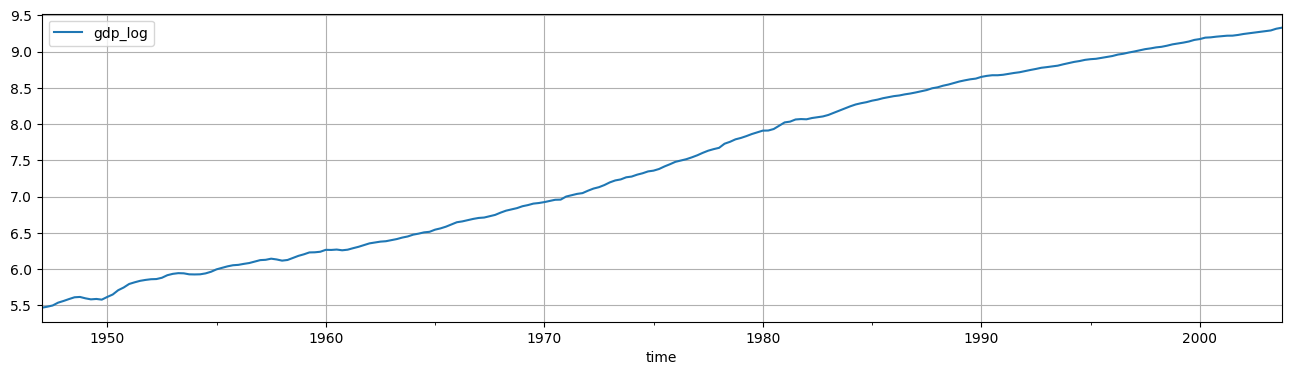

In [135]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
_ = gdp.gdp_log.plot(ax=ax, legend=True)
plt.grid()

A série apresenta uma forte tendência temporal

#### 2.a) Verifique se a série resultante é estacionária. Comprove com o teste de Dickey Fuller aumentado, justificando a escolha da defasagem.

In [137]:
# Teste de Dickey-Fuller aumentado com drift
adf_gdp = adfuller(gdp.gdp_log, regression='ct', maxlag=20, autolag='AIC')

print(f'ADF Statistic: {adf_gdp[0]}')
print(f'p-value: {adf_gdp[1]}')
print(f'Lags: {adf_gdp[2]}')

for key, value in adf_gdp[4].items():
    print('Critial Values:')
    print(f'    {key}: {value}')

ADF Statistic: -2.798063308372963
p-value: 0.19765668038012502
Lags: 18
Critial Values:
    1%: -4.0027517721652925
Critial Values:
    5%: -3.4317085320958416
Critial Values:
    10%: -3.139513599307244


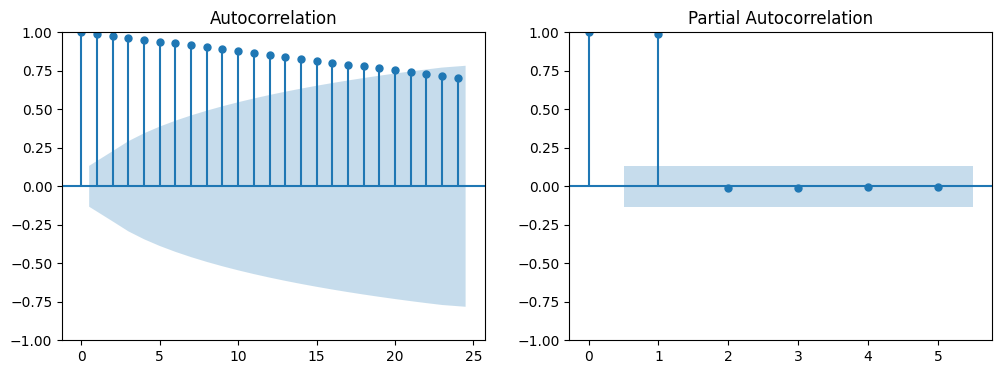

In [56]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
fig = statsmodels.graphics.tsaplots.plot_acf(gdp_train.gdp_log, lags=24, ax=ax1)
ax2 = fig.add_subplot(122)
fig = statsmodels.graphics.tsaplots.plot_pacf(gdp_train.gdp_log, lags=5, ax=ax2)
plt.show()

**Podemos observar uma forte autocorrelação entre muitos lags, característico de séries não estacionárias. Pela queda abrupta da PACF, podemos inferir que se trata de um moelo AR de ordem baixa, possivelmente AR(2) com integração**

In [95]:
p = range(0,4)
q = range(0,4)
d = range(0,2)
pdq = list(itertools.product(p,d,q))
pq = [(p,d,q) for p,d,q in pdq]

ARMA_aic = []
ARMA_pval = []

ljungbox_lag = 10

for param in pq:
    try:
        ARMA_ = ARIMA(gdp_train.gdp_log, order=param)
        res = ARMA_.fit()
        AUX = acorr_ljungbox(res.resid, lags=[ljungbox_lag])
        ARMA_pval.append(AUX.lb_pvalue[ljungbox_lag])
        ARMA_aic.append(res.aicc)
        if res.aicc <= min(ARMA_aic):
            BEST_param = param
    except Exception as e:
        print(e)
        print(f'Failed for param {param}')
        continue

#Gera tabela
data = {'AICc':  ARMA_aic,
        'Pval': ARMA_pval}

df_ARMA = pd.DataFrame(data, index = pq).rename_axis('ARMA',axis=1)
print(f"Melhor parâmetro: {BEST_param}")
df_ARMA

Melhor parâmetro: (3, 1, 2)


ARMA,AICc,Pval
"(0, 0, 0)",690.319743,0.000000e+00
"(0, 0, 1)",398.688689,0.000000e+00
"(0, 0, 2)",119.206759,1.019322e-301
"(0, 0, 3)",-114.805288,8.613432e-176
"(0, 1, 0)",-1064.293135,1.000000e+00
"(0, 1, 1)",-1179.622333,1.000000e+00
"(0, 1, 2)",-1250.839003,1.000000e+00
"(0, 1, 3)",-1277.145264,1.000000e+00
"(1, 0, 0)",-1052.009621,9.999998e-01
"(1, 0, 1)",-1170.215767,1.000000e+00


                               SARIMAX Results                                
Dep. Variable:                gdp_log   No. Observations:                  218
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 685.276
Date:                Fri, 04 Aug 2023   AIC                          -1358.551
Time:                        18:46:13   BIC                          -1338.272
Sample:                    01-01-1947   HQIC                         -1350.359
                         - 04-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4501      0.098      4.582      0.000       0.258       0.643
ar.L2          0.9733      0.105      9.302      0.000       0.768       1.178
ar.L3         -0.4263      0.063     -6.794      0.0

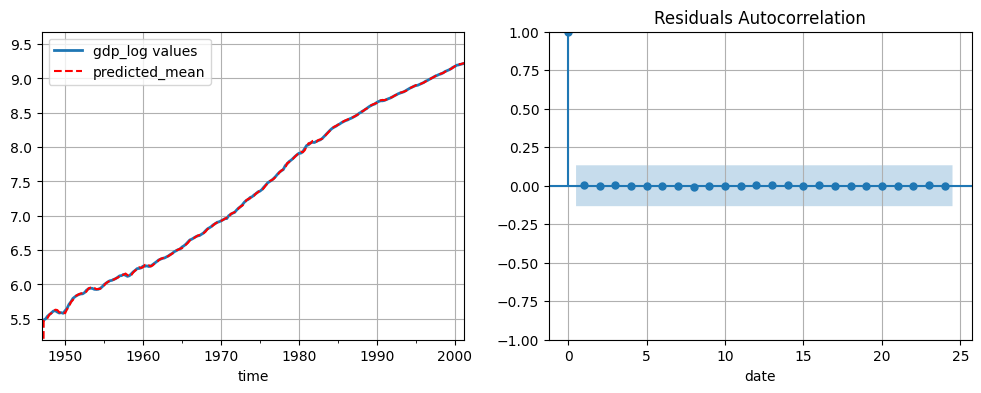

In [96]:
BEST_ARMA = ARIMA(gdp_train.gdp_log, order=BEST_param)
res_BEST_ARMA = BEST_ARMA.fit()
print(res_BEST_ARMA.summary())

BEST_ARMA_predict = pd.DataFrame(res_BEST_ARMA.predict())
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

gdp_train.gdp_log.plot(ax=ax1, lw=2, label='gdp_log values')
BEST_ARMA_predict.plot(ax=ax1, color='red', linestyle='--')

ax1.legend()
ax1.grid()
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_acf(res_BEST_ARMA.resid,ax=ax2)

plt.xlabel("lags")
ax1.set_ylim(0.95*min(gdp_train.gdp_log),1.05*max(gdp_train.gdp_log))

plt.title("Residuals Autocorrelation")
plt.xlabel("date")
plt.grid()
plt.show()

Pvalor: 1     0.972056
2     0.999202
3     0.999857
4     0.999994
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
Name: lb_pvalue, dtype: float64


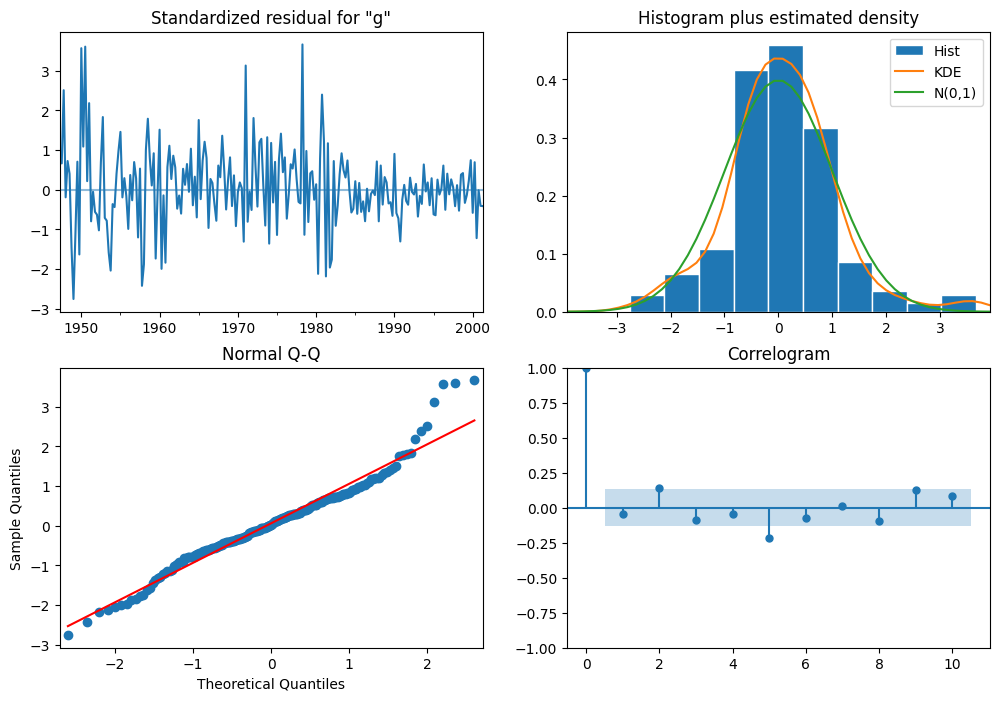

In [97]:
# Diagnóstico do resíduo do modelo
AUX = acorr_ljungbox(res_BEST_ARMA.resid)
AUX_Pval = AUX.lb_pvalue
print(f'Pvalor: {AUX_Pval}')
res_BEST_ARMA.plot_diagnostics(figsize=(12,8))
plt.show()

#### 2.c) Apresente as previsões de 1 a 10 passos à frente com o esse melhor modelo. Mostre o gráfico da previsão com intervalo de confiança de 95%.

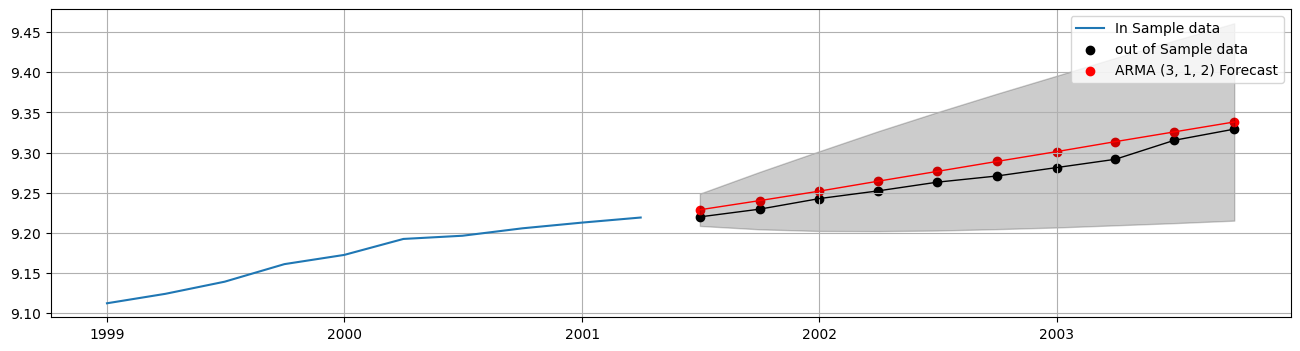

Forecast ARMA (3, 1, 2):
Model MAPE: 0.14%


gdp_log,mean,mean_se,mean_ci_lower,mean_ci_upper,gdp_log,abs_percent_error
2001-07-01,9.228781,0.010267,9.208657,9.248905,9.219914,0.000961
2001-10-01,9.240180,0.018238,9.204433,9.275926,9.229545,0.001151
2002-01-01,9.252024,0.025357,9.202326,9.301722,9.242740,0.001004
2002-04-01,9.264332,0.031722,9.202159,9.326506,9.252279,0.001301
2002-07-01,9.276542,0.037574,9.202898,9.350185,9.263123,0.001447
2002-10-01,9.288968,0.043017,9.204656,9.373279,9.270843,0.001951
2003-01-01,9.301197,0.048198,9.206731,9.395664,9.281339,0.002135
2003-04-01,9.313591,0.053159,9.209402,9.417781,9.291616,0.002359
2003-07-01,9.325776,0.057985,9.212128,9.439425,9.315331,0.001120
2003-10-01,9.338111,0.062687,9.215247,9.460975,9.329190,0.000955


In [133]:
periods = 10
index_ahead = gdp_test.index #Índice temporal para as previsões
fcast_BEST_ARMA = res_BEST_ARMA.get_forecast(periods)
fcast_BEST_ARMA_mean = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean']
fcast_BEST_ARMA_low = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_lower']
fcast_BEST_ARMA_up = fcast_BEST_ARMA.summary_frame(alpha=0.05)['mean_ci_upper']
fcast_BEST_ARMA_mean = fcast_BEST_ARMA_mean.rename('ARMA '+str(BEST_param)+' Forecast')

## Gráficos das previsões
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(gdp_train.index[-10:], gdp_train.gdp_log[-10:], label='In Sample data')
ax.scatter(gdp_test.index, gdp_test.gdp_log, color='k', lw=1, label='out of Sample data')
ax.plot(gdp_test.index, gdp_test.gdp_log, color='k', lw=1)

ax.scatter(gdp_test.index, fcast_BEST_ARMA_mean, color='r', lw=1, label=f'ARMA {BEST_param} Forecast')
ax.plot(gdp_test.index, fcast_BEST_ARMA_mean, color='r', lw=1)

ax.fill_between(index_ahead, fcast_BEST_ARMA_low, fcast_BEST_ARMA_up, color='k',alpha=0.2)
ax.legend()
plt.grid()
plt.show()

## Imprime as previsões
print(f'Forecast ARMA {BEST_param}:')
summary = fcast_BEST_ARMA.summary_frame(alpha=0.05)
summary['gdp_log'] = gdp_test['gdp_log']
summary['abs_percent_error'] = np.abs((summary['mean'] - summary['gdp_log'])/summary['mean'])
print(f'Model MAPE: {round(summary.abs_percent_error.mean()*100,2)}%')
summary

## 3) Considere a série Venda mensal de medicamentos cortezaesteróides na Austrália de 1992 a 2008 (h02), disponível eletronicamente em: https://www.otexts.org/fpp2

In [138]:
# Inicialização do Exercício 1
data = pd.read_csv('dados/h02.csv')
data.drop('time', inplace=True, axis=1)
data.drop('Unnamed: 0', inplace=True, axis=1)
data['time'] = pd.date_range('1991-07', periods=len(data['value']), freq='MS') #Cria escala de tempo trimestral (quarters)
data = data.set_index('time') #Cría índice temporal
print(data.describe().T)
data.tail()

       count      mean       std      min       25%       50%       75%  \
value  204.0  0.768153  0.225124  0.33622  0.588876  0.747136  0.937606   

            max  
value  1.257238  


,value
time,
2008-02-01,0.761822
2008-03-01,0.649435
2008-04-01,0.827887
2008-05-01,0.816255
2008-06-01,0.762137


In [139]:
data_train, data_test = train_test_split(data, test_size=0.04, shuffle=False)
data_test

,value
time,
2007-10-01,1.109979
2007-11-01,1.163534
2007-12-01,1.176589
2008-01-01,1.219941
2008-02-01,0.761822
2008-03-01,0.649435
2008-04-01,0.827887
2008-05-01,0.816255
2008-06-01,0.762137


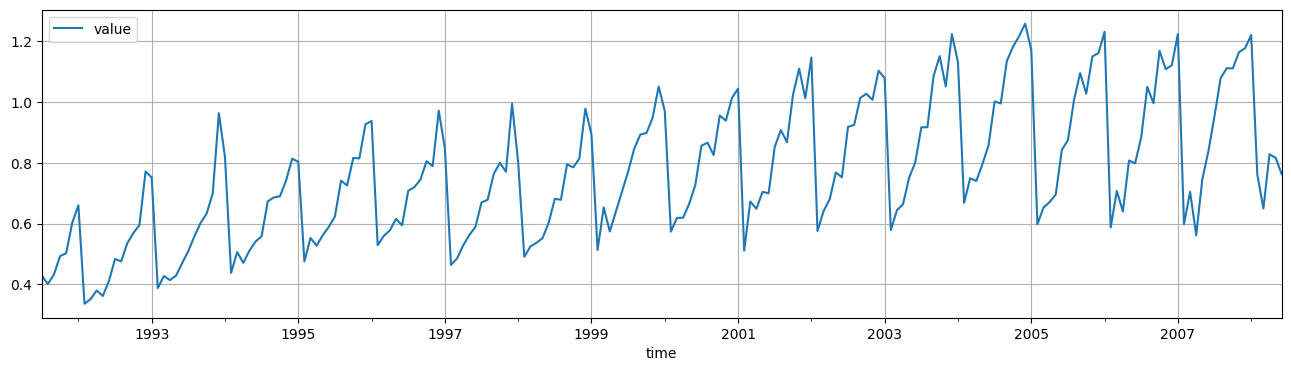

In [140]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
_ = data.value.plot(ax=ax, legend=True)
plt.grid()

#### 3.a) Verifique se a séria apresenta raiz unitária e sazonalidade. O que pode ser inferido sobre a sazonalidade?

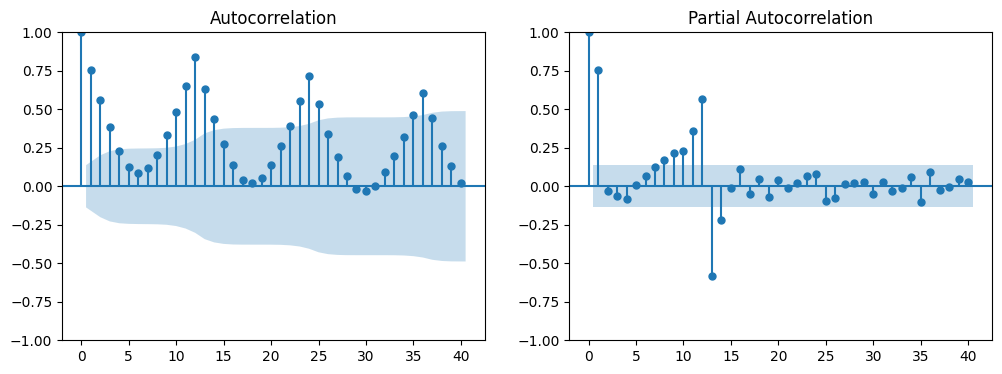

In [147]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
fig = statsmodels.graphics.tsaplots.plot_acf(data.value, lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = statsmodels.graphics.tsaplots.plot_pacf(data.value, lags=40, ax=ax2)
plt.show()

In [157]:
# Teste de Dickey-Fuller aumentado com drift
adf_gdp = adfuller(data.value, regression='c', maxlag=12, autolag='AIC')

print(f'ADF Statistic: {adf_gdp[0]}')
print(f'p-value: {adf_gdp[1]}')
print(f'Lags: {adf_gdp[2]}')

for key, value in adf_gdp[4].items():
    print('Critial Values:')
    print(f'    {key}: {value}')

ADF Statistic: -2.689611272942418
p-value: 0.07585328963428671
Lags: 12
Critial Values:
    1%: -3.465058702600837
Critial Values:
    5%: -2.8767942675230356
Critial Values:
    10%: -2.5749014492475535


#### 3.b) Obtenha um modelo ARIMA(p,0,q)(P,1,Q)[S] adequado para a série. Considere pmax = qmax = 3, Pmax = Qmax = 2. Justifique a escolha. Apresente os coeficientes do modelo.

##3.c) Apresente as previsões de 1 a 12 passos à frente com o esse melhor modelo. Mostre o gráfico da previsão com intervalo de confiança de 95%.

#4) Considere a série de retornos logaritmos do índice PETR4.SA 07/01/2013 a 23/12/2016.

In [ ]:
ticket = 'PETR4.SA'
data_inicio = '2013-01-07'
data_fim    = '2016-12-23'
dados = yf.download(ticket, start=data_inicio, end=data_fim)
# Cálculo do retorno logarítmico
dados['Return'] = np.log(dados['Adj Close'] / dados['Adj Close'].shift(1))
dados = dados.dropna()
tsdisplay(dados['Return'])
dados.head()

#4.a) Verifique se há heteroscedasticidade. Justifique!

##4.b) Obtenha os seguintes modelos para a volatilidade: EWMA com  = 0.96, ARCH(1), ARCH(10), GARCH(1,1), EGARCH(1,1) e GJR-GARCH(1,1). Faca o gráfico da série de retornos juntamente com a curva do desvio padrão condicional gerado para cada modelo. Apresente também as expressões dos modelos obtidos.

##Com os modelos ARCH(10) e GARCH(1,1), apresente as previsões da volatilidade (desvio padrão) condicional com horizonte de previsão h = 200. Apresente o gráfico das previsões e verifique que, para $h \rightarrow \infty$ [h tendendo ao infinito], as previsões convergem para os desvios padrões incondicionais dos modelos de volatilidade utilizados.